# **Feature Engineering Notebook**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

In [19]:
import os
print("Top-level folders:")
print(os.listdir("/workspaces"))

Top-level folders:
['heritage-house-price-predictor', '.codespaces']


In [22]:
os.chdir("/workspaces/heritage-house-price-predictor")
print(" Now in:", os.getcwd())

 Now in: /workspaces/heritage-house-price-predictor


## Setup and Load Data

We now load the cleaned Train and Test datasets created during the Data Cleaning stage.  
These datasets are ready for feature engineering.

In [23]:
import pandas as pd

train_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
test_path = "outputs/datasets/cleaned/TestSetCleaned.csv"

TrainSet = pd.read_csv(train_path)
TestSet = pd.read_csv(test_path)

TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1232,0.0,2.0,Av,724,GLQ,508,632,NaN,2007.0,...,7314,64.0,82.0,0,5,7,1232,2007,2007,194500
1,1445,689.0,5.0,No,0,Unf,844,441,Unf,1930.0,...,11888,69.0,0.0,60,6,6,844,1916,1994,214500
2,1337,0.0,3.0,Mn,699,GLQ,638,531,RFn,2003.0,...,8450,65.0,0.0,39,5,7,1337,2003,2003,185000
3,958,0.0,2.0,No,120,ALQ,958,440,RFn,1977.0,...,4928,69.0,0.0,205,5,6,1078,1976,1976,128000
4,1134,0.0,2.0,No,588,NaN,422,254,NaN,1960.0,...,7000,70.0,45.0,16,7,5,1010,1960,2002,135000


---

## Feature Engineering Utility Function

We define a custom function called `FeatureEngineeringAnalysis()` to evaluate how different feature transformations affect our variables.

This function helps us decide which transformations are most appropriate by:

- Visualizing the **distribution** (via histogram)
- Checking **normality** (via QQ plot)
- Identifying **outliers** (via boxplot)

We can use it to evaluate:
- **Ordinal Encoding** (for categorical features)
- **Numerical Transformation** (log, power, etc.)
- **Outlier Winsorization**

You don't need to understand every line of code immediately. Just focus on using this function to explore your variables and decide on the best transformations.

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

%matplotlib inline
def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        # Use the correct column name with suffix
        encoded_col = f"{column}_ordinal_encoder"
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng, encoded_col)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[column])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(column)
    except Exception:
        df_feat_eng.drop([column], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

---

## Ordinal Encoding

Some categorical variables have a natural order (e.g. Poor < Fair < Good < Excellent).  
We will convert them into numerical values using an Ordinal Encoder.  
This helps the model understand the ranking.

Features to encode:
- BsmtExposure
- BsmtFinType1
- GarageFinish
- KitchenQual

### Fill Missing Values in Ordinal Categorical Variables

Before we apply ordinal encoding, we must handle missing values.  
We use 'None' to indicate the absence of a feature (e.g. no basement or no garage).

In [25]:
ordinal_vars = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

# Fill missing values with 'None'
TrainSet[ordinal_vars] = TrainSet[ordinal_vars].fillna('None')
TestSet[ordinal_vars] = TestSet[ordinal_vars].fillna('None')

### Evaluate Ordinal Encoding

We create a copy of the ordinal variables and fill any missing values with `'None'`.

To match the expectations of our `FeatureEngineeringAnalysis()` function,  
we rename each variable by appending `_ordinal_encoder`.

This allows us to preview how ordinal encoding would impact each variable via histograms, QQ plots, and boxplots.

* Variable Analyzed: BsmtExposure
* Applied transformation: [] 



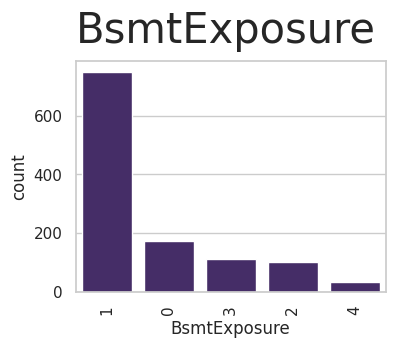





* Variable Analyzed: BsmtFinType1
* Applied transformation: [] 



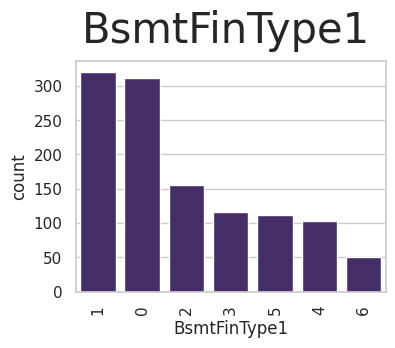





* Variable Analyzed: GarageFinish
* Applied transformation: [] 



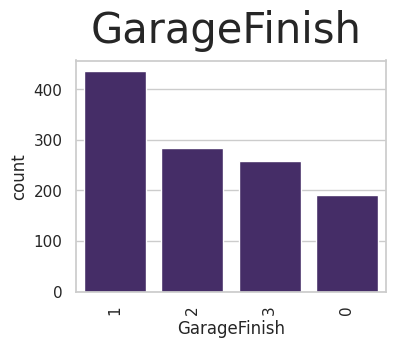





* Variable Analyzed: KitchenQual
* Applied transformation: [] 



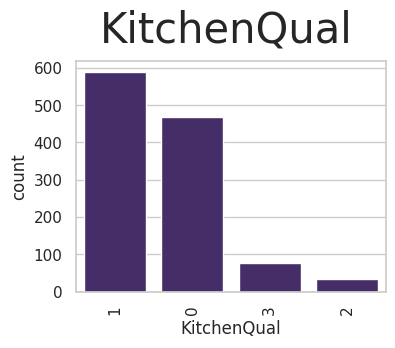

In [39]:
%matplotlib inline

# Step 1: Select variables
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

# Step 2: Create copy and fill missing
df_engineering = TrainSet[variables_engineering].copy()
df_engineering = df_engineering.fillna('None')

# Step 3: Directly evaluate encoding
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

In [26]:
from feature_engine.encoding import OrdinalEncoder

encoder = OrdinalEncoder(encoding_method='arbitrary', variables=ordinal_vars)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("Categorical encoding applied to:", ordinal_vars)

Categorical encoding applied to: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

---

## Numerical Transformation

We apply mathematical transformations to make the distribution of numerical features more normal.  
This helps improve model performance, especially for linear models.

- Log (base e): 1stFlrSF, GrLivArea  
- Power: TotalBsmtSF, GarageArea, BsmtFinSF1, BsmtUnfSF, YearBuilt, YearRemodAdd, OverallQual, OverallCond  
- Yeo-Johnson: LotArea, OpenPorchSF

In [27]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt

transformation_pipeline = Pipeline([
    ("log", vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
    ("power", vt.PowerTransformer(variables=[
        'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'BsmtUnfSF',
        'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond'
    ])),
    ("yeo", vt.YeoJohnsonTransformer(variables=['LotArea', 'OpenPorchSF']))
])

TrainSet = transformation_pipeline.fit_transform(TrainSet)
TestSet = transformation_pipeline.transform(TestSet)

print(" Numerical transformation completed.")

 Numerical transformation completed.


---

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
